In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.stats import norm

Initialize Stock Information and Bond Price array.

In [2]:
S0= 100             # Stock price today
K= 100              # Strike price
barrier = 150       # Barrier level
T= 1                # Maturity in years
n_simulation = 51   # number of simulations
sigmaj = 0.2
#Firm specific information
v0=200
debt=175
recovery_rate=0.25
correlation=0.2
t=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
bond_price=np.array([100,99.38,98.76,98.15,97.54,96.94,96.34,95.74,95.16,94.57,93.99,93.42,92.85])
gamma=0.75

Function to simulate contiuously compounded interest rate given Libor Rate from t(i+1) and t(i) at given time t(i)
t(i+1) - t(i) is taken as dt in the equation

In [3]:
def compound_interest(Libor,dt):
    return np.log(1 + Libor * dt) / dt

Simulating LIBOR interest rates based on the ZCB values given,
1) mc_forward stores the explicit Monte Carlo simulations and predcorr_forward contains the Predictor-Corrector Monte Carlo simulations
2) The array delta stores the time increments between bond maturities 
3) We store the compunded LIBOR interest estimates in r, the stock and firm volatilies in sigma_stock and sigma_firm respectively and the Stock Prices and Firm Prices in arrays S and V

Furthermore, we set the initial values of sigma_stock and sigma_firm as 1, since we are taking a cumulative product.
The zero index of arrays S and V contain the prices 100 and 200 respectively

In [4]:
# Applying the  LIBOR forward rate model algorithms and simulating interest rates.
np.random.seed(0)
n_simulations = 100000
n_steps = len(t)

mc_forward = np.ones([n_simulations,n_steps-1])*(bond_price[:-1]-bond_price[1:])/(2*bond_price[1:])
predcorr_forward = np.ones([n_simulations,n_steps-1])*(bond_price[:-1]-bond_price[1:])/(2*bond_price[1:])
predcorr_capfac = np.ones([n_simulations,n_steps])
mc_capfac = np.ones([n_simulations,n_steps])

delta = np.ones([n_simulations,n_steps-1])*(t[1:]-t[:-1])

corr_matrix = np.array([[1, correlation],[correlation, 1]])
norm_matrix = norm.rvs(size = np.array([2,n_simulations*n_steps]))
corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)

# Normal Random Variables for Stock and Firm value simulations
norm_stock = np.reshape(corr_norm_matrix[0,], (n_simulations, n_steps)) 
norm_firm = np.reshape(corr_norm_matrix[1,], (n_simulations, n_steps)) 

# Interest rate initialisation
r = compound_interest(predcorr_forward[0,0], delta[0,0])
r_sim = np.zeros([n_simulations,n_steps - 1])
r_sim[:,0] = r 

# Arrays to store sigma values for firm and stock path. Initial value is 1 since we take a cumulative product
sigma_stock = np.ones([n_simulations,n_steps - 1])
sigma_firm = np.ones([n_simulations,n_steps - 1])

# Arrays to hold Stock path and Firm values,
S = np.zeros([n_simulations,n_steps])
S[:,0] = S0

V = np.zeros([n_simulations,n_steps])
V[:,0] = v0 


Here, we simulate the LIBOR rates, Share Price path and Firm values simultaneously by taking 100000 simulations

In [5]:
for i in range(1,n_steps):
    Z = norm.rvs(size = [n_simulations,1])
    
    # Explicit Monte Carlo simulation
    muhat = np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis = 1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    # Predictor-Corrector Montecarlo simulation
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis = 1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis = 1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    #Simulating LIBOR rates
    r_sim[:,i:n_steps] = compound_interest(predcorr_forward[:,i:n_steps], delta[:,i:n_steps]) 
    
    # Simulating stock path
    sigma_stock[:,i-1] = 0.3*(S[:,i-1])**(gamma-1)
    S[:,i] = S[:,i-1]*np.exp((r_sim[:,i-1]-sigma_stock[:,i-1]**2/2)*(delta[:,i-1])+ sigma_stock[:,i-1]*norm_stock[:,i-1]*np.sqrt(delta[:,i-1]))
    
    # Simulating firm values
    sigma_firm[:,i-1] = 0.3*(V[:,i-1])**(gamma-1)
    V[:,i] = V[:,i-1]*np.exp((r_sim[:,i-1]-sigma_firm[:,i-1]**2/2)*(delta[:,i-1])+ sigma_firm[:,i-1]*norm_firm[:,i-1]*np.sqrt(delta[:,i-1]))
    
# Implying capitalisation factors from the forward rates

mc_capfac[:,1:] = np.cumprod(1+delta*mc_forward, axis = 1)
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward, axis = 1)

# Inverting the capitalisation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

# Taking averages
mc_final = np.mean(mc_price,axis = 0)
predcorr_final = np.mean(predcorr_price,axis = 0)

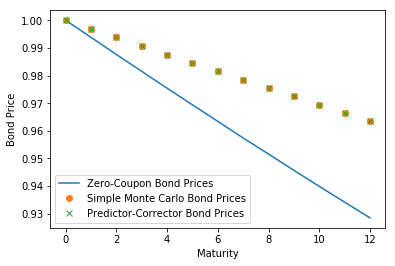

In [6]:
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,bond_price/100, label = "Zero-Coupon Bond Prices")
plt.plot(t,mc_final,'o', label = "Simple Monte Carlo Bond Prices")
plt.plot(t,predcorr_final,'x', label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

The discrepency in the bond prices graph results from the bond prices given. Since we did not calculate the bond values in the model, the simulations lines do not coincide with the observed values

Text(0, 0.5, 'Value')

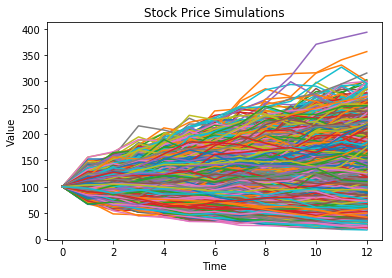

In [7]:
# Plot Stock prices path
plt.plot(np.transpose(S))
plt.title("Stock Price Simulations")
plt.xlabel("Time")
plt.ylabel("Value")

Just a simple graph to show the Share Prices path . Notice how all of them stem from the same starting point of S0 = 100

Text(0, 0.5, 'Value')

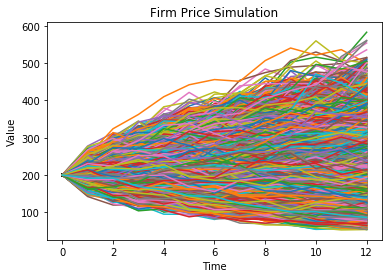

In [8]:
# Plot Firm value path
plt.plot(np.transpose(V))
plt.title("Firm Price Simulation")
plt.xlabel("Time")
plt.ylabel("Value")

Similarly, we plot the Firm values . All the paths stem from the same starting point of V0 = 200

Text(0, 0.5, 'Value')

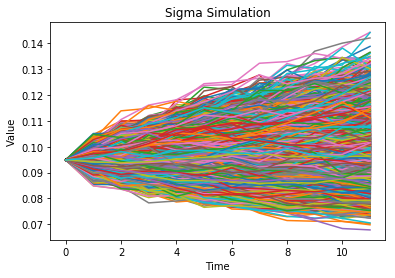

In [10]:
# Plot sigma for firm and stock values
plt.plot(np.transpose(sigma_stock))
plt.title("Sigma Simulation")
plt.xlabel("Time")
plt.ylabel("Value")

In [11]:
# Function to find payoff of call option
def find_call_payoff(S,r):
    return np.exp(-r * T) * np.maximum(S - K,0)

In [12]:
# Function to price and up and out call option
def up_and_out_call_price(S,r):
    total = 0
    out = np.max(S,axis = 1) > barrier
    for j in range(0, n_simulations):
        if out[j] == False:
            total += find_call_payoff(S[j, n_steps-1],r[j])
    return total/n_simulations


In [13]:
# Function to adjust call option value with counterparty risk (CVA)
def calculate_CVA(V, r, payoff):
    amount_lost = 0
    for i in range(0, n_simulations):
        if V[i, n_steps - 1] < debt:
            amount_lost += np.exp(-rT[i])*(1-recovery_rate)*payoff
    return amount_lost/n_simulations

Using the above functions, we calculate r by taking the sum of all the simulated interest rates over a period of one year and calculate the price of the up and out call option with and without considering counterparty risk

In [17]:
rT = T * np.sum(r_sim,axis = 1) / 12
payoff = np.round(up_and_out_call_price(S,rT),4)
print("Price of up and out Call Option : {}".format(payoff))


Price of up and out Call Option : 6.5262


In [19]:
cva_est = np.round(calculate_CVA(V,rT,payoff),4)
print("CVA Estimate : {}".format(cva_est))
print("Price of up and out call option adjusted with CVA : {}".format(payoff-cva_est))

CVA Estimate : 1.5096
Price of up and out call option adjusted with CVA : 5.0166
